# Along-slope velocity

Calculate the velocity component tangent to the a bathymetry contour.

Load modules

In [1]:
from pathlib import Path
import intake
from dask.distributed import Client
import numpy as np
import xarray as xr
import dask

import xgcm
import cf_xarray

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm
import pyproj

By default retain metadata after operations. This can retain out of date metadata, so some caution is required

In [2]:
xr.set_options(keep_attrs=True)

Start a cluster with multiple cores

In [3]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38155,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:35891,Total threads: 1
Dashboard: /proxy/34775/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:39557,


Open the catalogue & define experiment

In [4]:
experiment = '01deg_jra55v13_ryf9091'

In [5]:
catalog = intake.cat.access_nri
cat_filtered = catalog[experiment]
cat_filtered

,unique
path,11947
realm,2
variable,178
frequency,5
start_date,3361
end_date,3361
variable_long_name,181
variable_standard_name,36
variable_cell_methods,3
variable_units,50


Limit to Southern Ocean and single RYF year, as well as setting latitude and depth slices. We also set the data_frequency that we want to look for: `data_freq` to 3 monthly data.

In [6]:
latitude_slice  = slice(-80, -59)
depth_slice = slice(0,500)

start_time = '2086-01-01'
end_time   = '2086-12-31'

data_freq = '1mon'

Load bathymetry data. Discard the geolon and geolat coordinates: these are 2D curvilinear coordinates that are only required when working above 65N

In [7]:
# hu:  'hu': 'ocean depth on u-cells',
hu_vars = cat_filtered.search(variable='hu')

# We just want to grab the an instance, not concatenate them all
hu_var_path = hu_vars.df['path'][0]
hu_vars = hu_vars.search(path=hu_var_path)

# The entire dataset is only 37MiB, so open it without using dask - faster for small arrays
hu = hu_vars.to_dask(xarray_open_kwargs = {'chunks' : None})

# Drop the geolon, geolat coordinates
hu = hu.drop_vars(['geolat_c','geolon_c'])

# Select out our latitude slice, and then load the 'hu' variable into a dataarray 
hu = hu.sel(yu_ocean=latitude_slice).load()['hu']

hu

<xarray.DataArray 'hu' (yu_ocean: 484, xu_ocean: 3600)> Size: 7MB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [1685.9166, 1705.9722, 1783.7916, ..., 1646.8873, 1646.8873,
        1685.9166],
       [1552.4305, 1620.2222, 1706.6805, ..., 1541.7136, 1541.7136,
        1552.4305],
       [1459.0416, 1484.2361, 1545.4166, ..., 1494.3055, 1471.2222,
        1459.0416]], dtype=float32)
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point

Find the dataset we are after: we want monthly `u` and `v` data

In [8]:
uv_dataset = cat_filtered.search(variable=['u','v'],frequency=data_freq)

Load velocity data, limit to upper 500m and take the mean over time

In [9]:
# Time and st_ocean have size 200 & 75, respectively - so we specify to chunk each of these
# along the full dimension: `time : -1`, `st_ocean : -1`. 
# Split xu_ocean into three chunks, each of size 1200
chunk_spec = {
    'time' : -1,
    'st_ocean' : -1, 
    'xu_ocean': 1200
}

# We load the dataset of u & v variables into a dataarray with the chunking specified 
# above, select only the data for the latitude and depth ranges we decided to view earlier,
# and then average this data over the time dimension
uv_data_arr = (
    uv_dataset.to_dask(
        xarray_open_kwargs = {'chunks': chunk_spec} 
               ).sel(yu_ocean=latitude_slice
               ).sel(st_ocean=depth_slice
               ).mean(dim='time')
)
uv_data_arr

<xarray.Dataset> Size: 544MB
Dimensions:   (st_ocean: 39, yu_ocean: 484, xu_ocean: 3600)
Coordinates:
  * st_ocean  (st_ocean) float64 312B 0.5413 1.681 2.94 ... 383.0 423.7 468.4
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
Data variables:
    v         (st_ocean, yu_ocean, xu_ocean) float32 272MB dask.array<chunksize=(39, 274, 1200), meta=np.ndarray>
    u         (st_ocean, yu_ocean, xu_ocean) float32 272MB dask.array<chunksize=(39, 274, 1200), meta=np.ndarray>
Attributes:
    filename:                        ocean.nc
    title:                           ACCESS-OM2-01
    grid_type:                       mosaic
    grid_tile:                       1
    intake_esm_vars:                 ['v', 'u']
    intake_esm_attrs:realm:          ocean
    intake_esm_attrs:frequency:      1mon
    intake_esm_attrs:filename:       ocean.nc
    intake_esm_attrs:file_id:        ocean
    intake_esm_attrs:_data_format_:  netcdf
    intake_esm_dataset_key:          ocean.1mon

uv_data_arr has 1849 layers to combine 6 chunks due to the number of files it's opening, so we explicitly optimize the Dask Graph to reduce the size of the computation


In [10]:
uv_data_arr, = dask.optimize(uv_data_arr)
u, v = uv_data_arr['u'],uv_data_arr['v']
u

<xarray.DataArray 'u' (st_ocean: 39, yu_ocean: 484, xu_ocean: 3600)> Size: 272MB
dask.array<mean_agg-aggregate, shape=(39, 484, 3600), dtype=float32, chunksize=(39, 274, 1200), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 312B 0.5413 1.681 2.94 ... 383.0 423.7 468.4
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity

Load model grid information directly from a grid data file & drop coordinates we don't need.

- Currently, this works by getting the path of of the dataset we've been using from intake & appending `${_grid}` to it. Potentially smarter ways to go about this but intake needs patching before we can do so.

In [11]:
_fname = uv_dataset.df['path'][0]
fpath = Path(_fname)

fdir, fstem, fext = fpath.parent, fpath.stem, fpath.suffix

grid_filename = f"{fstem}_grid{fext}"

grid_filename =  Path(fdir / grid_filename)
grid = xr.open_dataset(grid_filename).drop_vars(['geolon_t', 'geolat_t', 'geolon_c', 'geolat_c'])   
grid

<xarray.Dataset> Size: 428MB
Dimensions:     (xt_ocean: 3600, yt_ocean: 2700, time: 1, xu_ocean: 3600,
                 yu_ocean: 2700)
Coordinates:
  * xt_ocean    (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean    (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
  * time        (time) object 8B 2151-04-01 00:00:00
  * xu_ocean    (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean    (yu_ocean) float64 22kB -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
Data variables:
    ht          (yt_ocean, xt_ocean) float32 39MB ...
    hu          (yu_ocean, xu_ocean) float32 39MB ...
    dxt         (yt_ocean, xt_ocean) float32 39MB ...
    dyt         (yt_ocean, xt_ocean) float32 39MB ...
    dxu         (yu_ocean, xu_ocean) float32 39MB ...
    dyu         (yu_ocean, xu_ocean) float32 39MB ...
    area_t      (yt_ocean, xt_ocean) float32 39MB ...
    area_u      (yu_ocean, xu_ocean) float32 39MB ...
    kmt         (yt_ocean, xt_ocean) float32 39MB ...
    kmu         (yu_ocean, xu_ocean) float32 39MB ...
    drag_coeff  (time, yu_ocean, xu_ocean) float32 39MB ...
Attributes:
    filename:   ocean_grid.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1

### Along-slope velocity

We calculate the along-slope velocity component by projecting the velocity field to the tangent vector, $u_{along} = \boldsymbol{u \cdot \hat{t}}$, and the cross-slope component by projecting to the normal vector, $v_{cross} = \boldsymbol{u \cdot \hat{n}}$. The schematic below defines the unit normal normal and tangent vectors for a given bathymetric contour, $\boldsymbol{n}$ and $\boldsymbol{t}$ respectively. 

![Sketch of topographic gradient](images/topographic_gradient_sketch.png)

Accordingly, the code below calculates the along-slope velocity component as

$$ u_{along} = (u,v) \boldsymbol{\cdot} \left(\frac{h_y}{|\nabla h|} , -\frac{h_x}{|\nabla h|}\right) = 
u \frac{h_y}{|\nabla h|} - v \frac{h_x}{|\nabla h|}, $$  

and similarly the cross-slope velocity component as

$$ v_{cross} = (u,v) \boldsymbol{\cdot} \left(\frac{h_x}{|\nabla h|} , \frac{h_y}{|\nabla h|}\right)  = 
u \frac{h_x}{|\nabla h|} + v \frac{h_y}{|\nabla h|}.$$ 


We need the derivatives of the bathymetry which we compute using the `xgcm` functionality.

In [12]:
# Give information on the grid: location of u (momentum) and t (tracer) points on B-grid 
ds = xr.merge([hu, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

# Create a grid with xgcm, which is periodic in the 'X' direction (ie. longitude)
grid = xgcm.Grid(ds, periodic=['X'])

# Take topographic gradient (simple gradient over one grid cell) and move back to u-grid
dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')

# In meridional direction, we need to specify what happens at the boundary
dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')

# Select latitude slice
dhu_dx = dhu_dx.sel(yu_ocean=latitude_slice)
dhu_dy = dhu_dy.sel(yu_ocean=latitude_slice)

# Magnitude of the topographic slope (to normalise the topographic gradient)
topographic_slope_magnitude = np.sqrt(dhu_dx**2 + dhu_dy**2)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


Calculate along-slope velocity component

In [13]:
# Along-slope velocity
alongslope_velocity = u * dhu_dy / topographic_slope_magnitude - v * dhu_dx / topographic_slope_magnitude
alongslope_velocity

<xarray.DataArray (st_ocean: 39, yu_ocean: 484, xu_ocean: 3600)> Size: 272MB
dask.array<sub, shape=(39, 484, 3600), dtype=float32, chunksize=(39, 274, 1200), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 312B 0.5413 1.681 2.94 ... 383.0 423.7 468.4
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity

Vertical averaging (we only need this to plot the velocity on a map)

N.B: `st_edges_ocean` isn't searchable in the catalogue - this is because it's a coordinate and not a variable.

- To get around this, we grab the first file from the dataset we have used - and build it from there


In [14]:
ds = xr.open_dataset(_fname)
st_edges_ocean, st_ocean = ds.coords['st_edges_ocean'], ds.coords['st_ocean']

st_edges_array = st_edges_ocean.expand_dims({'yu_ocean': u.yu_ocean, 'xu_ocean': u.xu_ocean}, axis=[1, 2])

In [15]:
# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))
thickness = thickness.sel(st_ocean=depth_slice)

# Depth average gives us the barotropic velocity
barotropic_alongslope_velocity = (alongslope_velocity * thickness).sum('st_ocean') / thickness.sum('st_ocean')
barotropic_alongslope_velocity

<xarray.DataArray (yu_ocean: 484, xu_ocean: 3600)> Size: 14MB
dask.array<truediv, shape=(484, 3600), dtype=float64, chunksize=(274, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity

### Plotting

Create a circular path to clip plots

In [16]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.45
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

Create a land mask for plotting, set land cells to 1 and rest to NaN

In [17]:
land = xr.where(np.isnan(hu.rename('land')), 1, np.nan)

## Map of along-slope velocity with bathymetry contours

Warnings will occur in points where we divide by NaN/0 in computation barotropic velocity,
i.e., when there is no topographic gradient and warning can be ignored

At monthly frequency, this call can be quite slow - on the order of 40 minutes 
on a large ARE instance. Changine frequency to 3 monthly will bring it down to a 
few minutes

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 555.26 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.p

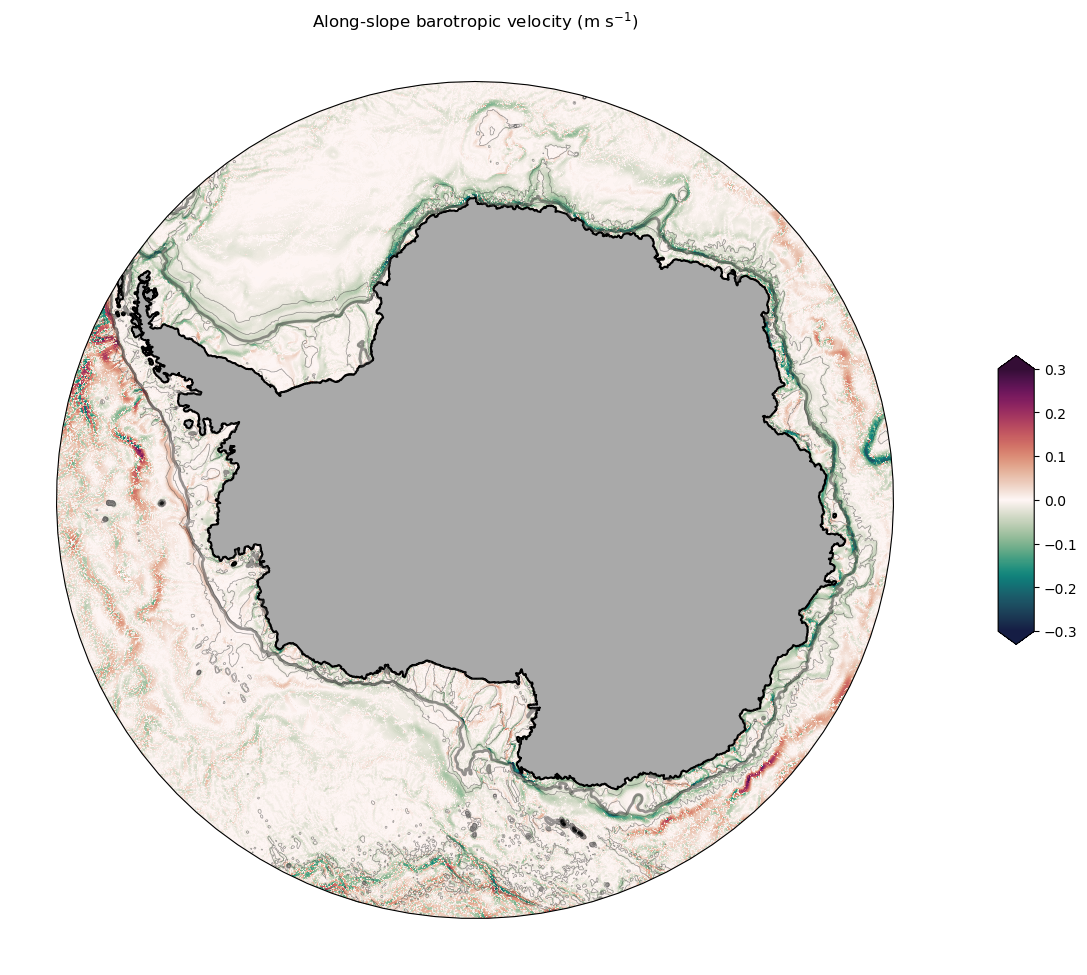

In [18]:
fig = plt.figure(1, figsize=(15, 15))

ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo(), facecolor="darkgrey")
ax.set_boundary(circle, transform=ax.transAxes)
    
# Filled land 
land.plot.contourf(ax=ax, colors='darkgrey', zorder=2,
                   transform=ccrs.PlateCarree(), add_colorbar=False)

# Coastline
land.fillna(0).plot.contour(ax=ax, colors='k', levels=[0, 1],
                            transform=ccrs.PlateCarree(), add_colorbar=False)

# Depth contours
hu.plot.contour(ax=ax, levels=[500, 1000, 2000, 3000],
                colors='0.2', linewidths=[0.5, 2, 0.5, 0.5], alpha=0.5,
                transform=ccrs.PlateCarree())

# Along slope barotropic velocity
sc = barotropic_alongslope_velocity.plot(ax = ax, cmap=cm.cm.curl,
                                         transform=ccrs.PlateCarree(), vmin=-0.3, vmax=0.3,
                                         cbar_kwargs={'orientation': 'vertical',
                                                      'shrink': 0.25,
                                                      'extend': 'both',
                                                      'label': None,
                                                      'aspect': 8})
  
ax.set_title('Along-slope barotropic velocity (m s$^{-1}$)')
plt.show()

In [19]:
client.close()